# 01 Baseline
The purpose of this work is to get acquainted with the data and determine the minimum quality level.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
from IPython.display import Image

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import RepeatedStratifiedKFold

import spacy
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score, f1_score

In [2]:
df = pd.read_csv('dataset/aboutlabeled.csv')
df

,Text,Label,ID,Offsets,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Funding Circle was created with a big idea:,None,article_00000.pre.xmi:001,[],NaN,NaN,NaN
1,To revolutionize the outdated banking system a...,About,article_00000.pre.xmi:002,[{u'text': u'revolutionize the outdated bankin...,NaN,NaN,NaN
2,"Thousands of loans later, we've helped busines...",About,article_00000.pre.xmi:003,"[{u'text': u'we', u'endOffset': 28, u'beginOff...",NaN,NaN,NaN
3,We've taken this progress global.,About,article_00000.pre.xmi:004,"[{u'text': u'We', u'endOffset': 2, u'beginOffs...",NaN,NaN,NaN
4,Funding Circle is the world's leading marketpl...,About,article_00000.pre.xmi:005,"[{u'text': u'Funding Circle', u'endOffset': 14...",NaN,NaN,NaN
...,...,...,...,...,...,...,...
16716,Dr. Holtz has held research management positio...,None,article_00799.pre.xmi:013,[],NaN,NaN,NaN
16717,He received his Ph.D. at Pennsylvania State Un...,None,article_00799.pre.xmi:014,[],NaN,NaN,NaN
16718,Dr. Holtz has been awarded 22 US patents and h...,None,article_00799.pre.xmi:015,[],NaN,NaN,NaN
16719,Dr. Holtz was awarded the Pennsylvania State U...,None,article_00799.pre.xmi:016,[],NaN,NaN,NaN


### Check "unnamed: 4-6"

In [3]:
rows = df[~df['Unnamed: 4'].isnull()]
rows

,Text,Label,ID,Offsets,Unnamed: 4,Unnamed: 5,Unnamed: 6
678,Venus is different,our network was built with the needs of the b...,None,article_00038.pre.xmi:007,[],NaN,NaN
1122,We do not look to spread product functionality...,nor do we try to straight-jacket your process...,None,article_00058.pre.xmi:034,[],NaN,NaN
1128,We really want to make sure that we have under...,that together we understand all the issues an...,None,article_00058.pre.xmi:040,[],NaN,NaN
2255,The result is tribal knowledge vs. institution...,lack of visibility into performance creates s...,manual change management practices leading to...,None,article_00110.pre.xmi:008,[],NaN
2648,Managing Director of ionStar,a company that provides regulatory compliance...,About,article_00128.pre.xmi:025,"[{u'text': u'ionStar', u'endOffset': 28, u'beg...",NaN,NaN
...,...,...,...,...,...,...,...
15644,Roland was co-founder of Zimbra (acquired by Y...,co-founder & CTO of mobile-messaging company ...,founding engineer at Onebox.com (acquired by ...,About,article_00753.pre.xmi:016,"[{u'text': 'mobile-messaging', u'endOffset': 9...",NaN
15660,Ross was co-founder of Zimbra (acquired by Yah...,cofounder of mobile-messaging company Mumbo (...,founding engineer at Onebox.com (acquired for...,and is a principal at investment firm Volt Ve...,About,article_00753.pre.xmi:032,"[{u'text': 'mobile-messaging', u'endOffset': 9..."
16148,We stand for high-performance,taking a different approach to making the ine...,None,article_00775.pre.xmi:009,[],NaN,NaN
16370,Our customer roster includes internet commerce...,higher education institutions ranging from th...,international industrial behemoths and retail...,and house hold names in the highly regulated ...,About,article_00783.pre.xmi:012,"[{u'text': u'Our', u'endOffset': 3, u'beginOff..."


### Fixing incorrect escaping

In [4]:
regex_str = re.compile(r"(.+?),(About|None),(article_.+?),(.*)") 

df_row_list = []
f_in = open ('dataset/aboutlabeled.csv', 'r')
for i, line in enumerate(f_in):
    if i > 0:
        r_match = re.match(regex_str, line)
        df_row = [r_match[1], r_match[2], r_match[3], r_match[4]]
        df_row_list.append(df_row)
f_in.close()      

df = pd.DataFrame(df_row_list)
df.columns = ['Text', 'Label', 'ID', 'Offsets']

In [5]:
df

,Text,Label,ID,Offsets
0,Funding Circle was created with a big idea:,None,article_00000.pre.xmi:001,"[],,,"
1,To revolutionize the outdated banking system a...,About,article_00000.pre.xmi:002,"""[{u'text': u'revolutionize the outdated banki..."
2,"""Thousands of loans later, we've helped busine...",About,article_00000.pre.xmi:003,"""[{u'text': u'we', u'endOffset': 28, u'beginOf..."
3,We've taken this progress global.,About,article_00000.pre.xmi:004,"""[{u'text': u'We', u'endOffset': 2, u'beginOff..."
4,"""Funding Circle is the world's leading marketp...",About,article_00000.pre.xmi:005,"""[{u'text': u'Funding Circle', u'endOffset': 1..."
...,...,...,...,...
16716,Dr. Holtz has held research management positio...,None,article_00799.pre.xmi:013,"[],,,"
16717,He received his Ph.D. at Pennsylvania State Un...,None,article_00799.pre.xmi:014,"[],,,"
16718,Dr. Holtz has been awarded 22 US patents and h...,None,article_00799.pre.xmi:015,"[],,,"
16719,"""Dr. Holtz was awarded the Pennsylvania State ...",None,article_00799.pre.xmi:016,"[],,,"


### Encode y

In [6]:
df.loc[df['Label'] == 'None', 'Label'] = 0
df.loc[df['Label'] == 'About', 'Label'] = 1
df['Label'] = df['Label'].astype(int)

### Drop uninformative columns. I don't go deep into "Offsets", because DL model will do it.

In [7]:
df.drop(['ID', 'Offsets'], axis=1, inplace=True)
df.dropna(inplace=True)

In [8]:
df

,Text,Label
0,Funding Circle was created with a big idea:,0
1,To revolutionize the outdated banking system a...,1
2,"""Thousands of loans later, we've helped busine...",1
3,We've taken this progress global.,1
4,"""Funding Circle is the world's leading marketp...",1
...,...,...
16716,Dr. Holtz has held research management positio...,0
16717,He received his Ph.D. at Pennsylvania State Un...,0
16718,Dr. Holtz has been awarded 22 US patents and h...,0
16719,"""Dr. Holtz was awarded the Pennsylvania State ...",0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16721 entries, 0 to 16720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    16721 non-null  object
 1   Label   16721 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 391.9+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Label', ylabel='count'>

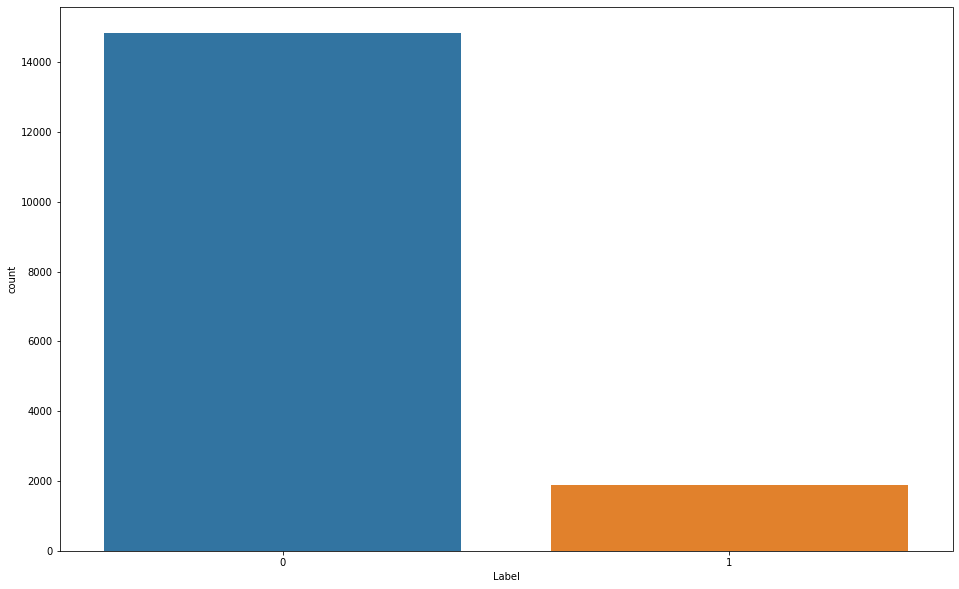

In [10]:
import seaborn as sns

sns.countplot(df['Label'])

The classes are not balanced, that's okay.

### Tokening the Data with spaCy

In [11]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from tqdm import tqdm

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer
parser = English()

# Creating our tokenizer function
def cleanup_text(docs):
    texts = []
    for doc in tqdm(docs, ncols=80):
        doc = nlp(doc, disable=['parser', 'ner'])
#         tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok.lemma_.lower().strip() for tok in doc]
        #tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
        tokens = [tok for tok in tokens if tok not in punctuations] #stop_words improve cross validation score
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return texts

df['Сlean text'] = cleanup_text(df['Text'])

100%|████████████████████████████████████| 16721/16721 [00:32<00:00, 519.82it/s]


In [12]:
df

,Text,Label,Сlean text
0,Funding Circle was created with a big idea:,0,funding circle be create with a big idea
1,To revolutionize the outdated banking system a...,1,to revolutionize the outdated banking system a...
2,"""Thousands of loans later, we've helped busine...",1,thousand of loan later we 've help business ex...
3,We've taken this progress global.,1,we 've take this progress global
4,"""Funding Circle is the world's leading marketp...",1,funding circle be the world 's lead marketplac...
...,...,...,...
16716,Dr. Holtz has held research management positio...,0,dr. holtz have hold research management positi...
16717,He received his Ph.D. at Pennsylvania State Un...,0,he receive his ph.d. at pennsylvania state uni...
16718,Dr. Holtz has been awarded 22 US patents and h...,0,dr. holtz have be award 22 us patent and have ...
16719,"""Dr. Holtz was awarded the Pennsylvania State ...",0,dr. holtz be award the pennsylvania state univ...


### We do not touch the test samples.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Label'], test_size=0.2, stratify=df['Label'])

In [14]:
df = X_train.copy()

### Simple check for duplicates
It needs a good function to evaluate the uniqueness of the text. 
To save time in the baseline, I am not doing research.

In [15]:
df.drop_duplicates(subset=['Text'], keep='last', inplace=True)
df.drop_duplicates(subset=['Сlean text'], keep='last', inplace=True)

In [16]:
import Levenshtein

max_distance_list = []
text_list = list(df['Сlean text'])

t = tqdm(range(df.shape[0]-1), ncols=80)

for a in t:
    max_distance = float('-inf')    
    a_text = text_list[a]    
    for b, (b_text) in enumerate(text_list):
        if a == b: continue
        distance = Levenshtein.ratio(a_text, b_text)
        if distance > max_distance: 
            max_distance = distance
    max_distance_list.append(max_distance)
max_distance_list.append(0.5)
df["Distance"] = max_distance_list

100%|█████████████████████████████████████| 12311/12311 [02:19<00:00, 88.51it/s]


In [17]:
df

,Text,Label,Сlean text,Distance
16355,"""Monday through Friday - 9:30am, 12:00n, 2:30p...",0,monday through friday 9:30am 12:00n 2:30pm 6:00pm,0.602740
8696,Looking Forward,0,look forward,0.800000
12529,We strive for a culture that truly believes in...,0,we strive for a culture that truly believe in ...,0.614173
1373,"""Offset Print & Packaging operate from a state...",0,offset print packaging operate from a state of...,0.527881
13280,The result is high-quality furniture made just...,0,the result be high quality furniture make just...,0.557692
...,...,...,...,...
6446,"""At Farm Service, Inc., you'll find a full-lin...",1,at farm service inc. you 'll find a full line ...,0.600000
7752,"""Collin has university sales and leadership ce...",0,collin have university sale and leadership cer...,0.500000
3258,"""Co-Founder, Product Manager""",0,co founder product manager,0.818182
6576,"""At Google, Prem leads Google's health efforts...",0,at google prem lead google 's health effort in...,0.519481


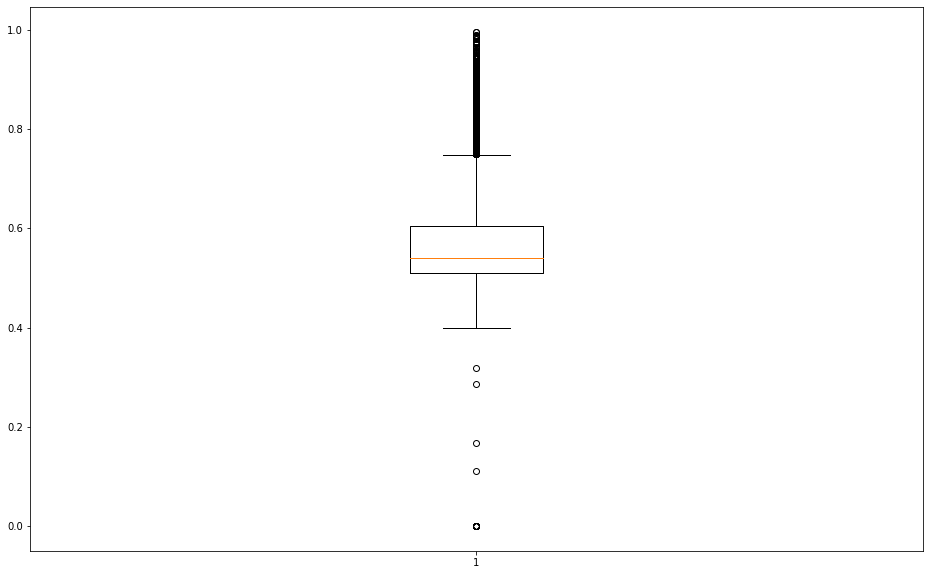

In [18]:
plt.boxplot(df['Distance'])
plt.show()

In [19]:
q1 = np.quantile(df['Distance'], 0.25)
q3 = np.quantile(df['Distance'], 0.75)
med = np.median(df['Distance'])
iqr = q3-q1
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

0.09539190353143845 0.7477390180878554 0.3661714039621015


In [20]:
df[(df['Distance'] > upper_bound) & (df['Label'] == 1)].count()

Text          22
Label         22
Сlean text    22
Distance      22
dtype: int64

In [21]:
df[(df['Distance'] >= 1) & (df['Label'] == 1)].count()

Text          0
Label         0
Сlean text    0
Distance      0
dtype: int64

In [22]:
df[(df['Distance'] > upper_bound) & (df['Label'] == 0)].count()

Text          955
Label         955
Сlean text    955
Distance      955
dtype: int64

In [23]:
df[(df['Distance'] >= 1) & (df['Label'] == 0)].count()

Text          0
Label         0
Сlean text    0
Distance      0
dtype: int64

#### Removing non-unique rows

In [24]:
df.drop(df[df['Distance'] >= 1].index, axis=0, inplace=True)
df.drop(df[(df['Distance'] >= 1) & (df['Label'] == 1)].index, axis=0, inplace=True)
df.drop(df[(df['Distance'] > upper_bound) & (df['Label'] == 0)].index, axis=0, inplace=True)

In [25]:
df[df.duplicated(subset=['Сlean text'])]

,Text,Label,Сlean text,Distance


In [26]:
df

,Text,Label,Сlean text,Distance
16355,"""Monday through Friday - 9:30am, 12:00n, 2:30p...",0,monday through friday 9:30am 12:00n 2:30pm 6:00pm,0.602740
12529,We strive for a culture that truly believes in...,0,we strive for a culture that truly believe in ...,0.614173
1373,"""Offset Print & Packaging operate from a state...",0,offset print packaging operate from a state of...,0.527881
13280,The result is high-quality furniture made just...,0,the result be high quality furniture make just...,0.557692
5140,"""Steve has worked with some of the largest glo...",0,steve have work with some of the large global ...,0.495114
...,...,...,...,...
560,"""Consistent with our commitment to customer se...",1,consistent with our commitment to customer ser...,0.504792
6446,"""At Farm Service, Inc., you'll find a full-lin...",1,at farm service inc. you 'll find a full line ...,0.600000
7752,"""Collin has university sales and leadership ce...",0,collin have university sale and leadership cer...,0.500000
6576,"""At Google, Prem leads Google's health efforts...",0,at google prem lead google 's health effort in...,0.519481


### Simple improving distribution and independence

In [27]:
# df.loc[df['Label'] == 1, 'w'] = 1.
# df.loc[df['Label'] == 0, 'w'] = 1. - df['Distance']
# df.loc[df['Label'] == 0, 'w'] = (df['w'] - df['w'].min()) / (df['w'].max() - df['w'].min())

df['w'] = 1. - df['Distance']
df['w'] = (df['w'] - df['w'].min()) / (df['w'].max() - df['w'].min())

In [28]:
X = df['Сlean text']
y = df['Label']
w = df['w'].astype('float32')

### Search for hyperparameters, using the statistically unreliable k-fold test. (To save time in the baseline)

#### Rewriting cross_val_score because sklearn cross_val_score does not support weights.

In [29]:
from typing import Callable
from joblib import Parallel, delayed
from sklearn.base import clone

def cross_val_score(
        clf, 
        X: pd.DataFrame,
        y: pd.Series,
        cv_gen,
        sample_weight_train: np.ndarray = None,
        scoring: Callable[[np.array, np.array], float] = roc_auc_score,
        n_jobs = -1):

    # If no sample_weight then broadcast a value of 1 to all samples (full weight).
    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))
        
    if isinstance(cv_gen, list): cv_gen_list = cv_gen
    else: cv_gen_list = list(cv_gen.split(X=X, y=y))      
                        
    def calc_fold(train, test):

        if hasattr(X, 'iloc'):                
            X_train_ = X.iloc[train]
            X_test_ = X.iloc[test]

            y_train_ = y.iloc[train]
            y_test_ = y.iloc[test]
            
            w_train_ = sample_weight_train.iloc[train]

        else:
            X_train_ = X[train]
            X_test_ = X[test]

            y_train_ = y[train]
            y_test_ = y[test]
            
            w_train_ = sample_weight_train[train]

        classifier = clone(clf)
        fit = classifier.fit(X = X_train_, y = y_train_, 
                             rf_classifier__sample_weight=w_train_)

        if scoring == roc_auc_score:
            prob = fit.predict_proba(X_test_)[:, 1]
            score = scoring(y_test_, prob)
        else:
            pred = fit.predict(X_test_)
            score = scoring(y_test_, pred)

        return score
        
    # Score model on Folds
    ret_scores = Parallel(n_jobs=n_jobs)(delayed(calc_fold)(train, test) for train, test in cv_gen_list)
        
    return np.array(ret_scores)

In [30]:
def objective(trial):

    rf_n_estimators = trial.suggest_int("rf_n_estimators", 800, 1200, 100)
    rf_max_depth = trial.suggest_int("rf_max_depth", 14, 18)
    
    tfidf_max_features = trial.suggest_int("tfidf_max_features", 6000, 9000, 100)
    tfidf_min_df = trial.suggest_int("tfidf_min_df", 1, 6, 1)
    tfidf_max_df = trial.suggest_float("tfidf_max_df", 0.17, 0.37, step=0.01)
    

    rf_classifier = RandomForestClassifier(n_estimators=rf_n_estimators, criterion='entropy', 
                                           max_depth=rf_max_depth, n_jobs=-1, class_weight='balanced_subsample')

    
    clf=Pipeline([
            ('tfidf_vectorizer', TfidfVectorizer(max_features=tfidf_max_features, ngram_range=(1,3),
                                                 min_df=tfidf_min_df, max_df=tfidf_max_df)),
            ('rf_classifier', rf_classifier)
        ])
    
    cv_gen = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
    cv_gen_list = list(cv_gen.split(X, y))
    
    new_score = cross_val_score(clf,
                                X=X, y=y,
                                cv_gen=cv_gen_list,
                                sample_weight_train=w,
                                scoring=f1_score,
                                )

    return new_score.mean()

In [31]:
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print ("Best score", study.best_value)
print ("Best params", study.best_params)

[I 2021-08-23 16:18:16,713] A new study created in memory with name: no-name-1252b444-3923-4c6c-af07-345b54d04e2e
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:46: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2021-08-23 16:18:41,790] Trial 0 finished with value: 0.5147993256998497 and parameters: {'rf_n_estimators': 1100, 'rf_max_depth': 18, 'tfidf_max_features': 8300, 'tfidf_min_df': 1, 'tfidf_max_df': 0.34}. Best is trial 0 with value: 0.5147993256998497.
[I 2021-08-23 16:19:06,274] Trial 1 finished with value: 0.5310113771100033 and parameters: {'rf_n_estimators': 1200, 'rf_max_depth': 17, 'tfidf_max_features': 7800, 'tfidf_min_df': 1, 'tfidf_max_df': 0.31000000000000005}. Best is trial 1 with value: 0.5310113771100033.
[I 2021-08-23 16:19:30,660] Trial 2 finished with value: 0.5316894155665355 and parameters: {'rf_n_estimators': 1200, 'rf_max_depth': 17, 'tfidf_max_features': 6400, 'tfidf_min_df': 4, 'tfidf_max_df': 0.24000000000000002}. Best is trial 2 with value: 0.5316894155665355.
[I 2021-08-23 16:19:53,298] Trial 3 finished with value: 0.5344598649840042 and parameters: {'rf_n_estimators': 1200, 'rf_max_depth': 15, 'tfidf_max_features': 8200, 'tfidf_min_df': 1, 'tfidf_max_df': 0

[I 2021-08-23 16:29:25,651] Trial 31 finished with value: 0.5307909632573449 and parameters: {'rf_n_estimators': 1000, 'rf_max_depth': 15, 'tfidf_max_features': 8800, 'tfidf_min_df': 3, 'tfidf_max_df': 0.26}. Best is trial 3 with value: 0.5344598649840042.
[I 2021-08-23 16:29:44,971] Trial 32 finished with value: 0.5375678328763508 and parameters: {'rf_n_estimators': 1000, 'rf_max_depth': 15, 'tfidf_max_features': 9000, 'tfidf_min_df': 3, 'tfidf_max_df': 0.30000000000000004}. Best is trial 32 with value: 0.5375678328763508.
[I 2021-08-23 16:30:03,599] Trial 33 finished with value: 0.5271062627012146 and parameters: {'rf_n_estimators': 900, 'rf_max_depth': 17, 'tfidf_max_features': 9000, 'tfidf_min_df': 3, 'tfidf_max_df': 0.31000000000000005}. Best is trial 32 with value: 0.5375678328763508.
[I 2021-08-23 16:30:22,985] Trial 34 finished with value: 0.5341461459332962 and parameters: {'rf_n_estimators': 1000, 'rf_max_depth': 15, 'tfidf_max_features': 8600, 'tfidf_min_df': 4, 'tfidf_max_d

In [32]:
# 0.5418288132882823

### Test on test data

In [33]:
rf_classifier = RandomForestClassifier(n_estimators=study.best_params['rf_n_estimators'], criterion='entropy', 
                                       max_depth=study.best_params['rf_max_depth'], n_jobs=-1, class_weight='balanced_subsample')

clf=Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(max_features=study.best_params['tfidf_max_features'], 
                                             min_df=study.best_params['tfidf_min_df'],
                                             max_df=study.best_params['tfidf_max_df'],
                                            )),
        ('rf_classifier', rf_classifier)
    ])

In [34]:
clf.fit(X, y, rf_classifier__sample_weight=w)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.30000000000000004, max_features=9000,
                                 min_df=3)),
                ('rf_classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=15,
                                        n_estimators=1000, n_jobs=-1))])

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2969
           1       0.42      0.66      0.52       376

    accuracy                           0.86      3345
   macro avg       0.69      0.77      0.72      3345
weighted avg       0.89      0.86      0.87      3345

Confusion Matrix
[[2632  337]
 [ 128  248]]

Roc auc score
0.7730341185154397

Target score
0.5161290322580645


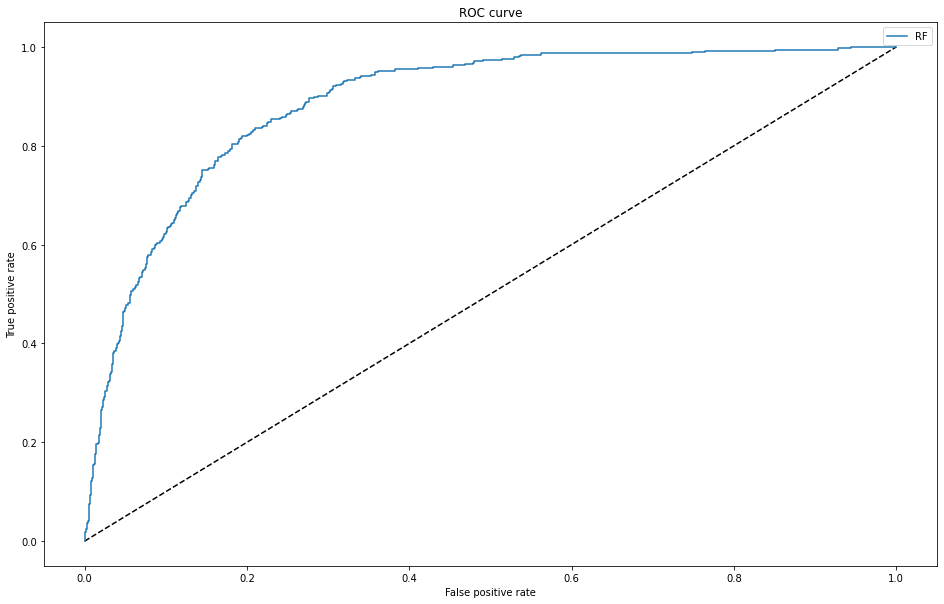

In [35]:
y_pred_rf = clf.predict_proba(X_test['Сlean text'])[:, 1]
y_pred = clf.predict(X_test['Сlean text'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Roc auc score")
print(roc_auc_score(y_test, y_pred))

print('')
print("Target score")
print(f1_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()